Data Source: https://archive.ics.uci.edu/dataset/732/darwin<br>
<br>
The DARWIN dataset includes handwriting data from 174 participants. The classification task consists in distinguishing Alzheimer’s disease patients from healthy people.<br>
<br>
Dataset Characteristics<br>
Tabular
<br>
Subject Area<br>
Health and Medicine<br>
<br>
Associated Tasks<br>
Classification<br>
<br>
Feature Type<br>
-<br>
<br>
Number of Instances<br>
174<br>
<br>
Number of Features<br>
451<br>

Source of Original Paper: <br>
* https://www.sciencedirect.com/science/article/abs/pii/S0952197622000902

### Note: this data set has more features than instances

## Data Loading

In [1]:
# installer from uci:

# pip install ucimlrepo

In [2]:
# execute this cell to load the dataset from the internet into X and y (each time you execute this)
""" 
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
darwin = fetch_ucirepo(id=732) 
  
# data (as pandas dataframes) 
X = darwin.data.features 
y = darwin.data.targets 
  
# metadata 
print(darwin.metadata) 
  
# variable information 
print(darwin.variables)  
"""


' \nfrom ucimlrepo import fetch_ucirepo \n  \n# fetch dataset \ndarwin = fetch_ucirepo(id=732) \n  \n# data (as pandas dataframes) \nX = darwin.data.features \ny = darwin.data.targets \n  \n# metadata \nprint(darwin.metadata) \n  \n# variable information \nprint(darwin.variables)  \n'

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

#columns = [...]
sourcepath = Path(r".\Data\DARWIN\DARWIN\DARWIN.csv".replace("\\", "/"))
data = pd.read_csv(sourcepath)

data.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


The column with name "class" seems to be the target variable.

## To Do: 
1. wie kann man die vielen Spalten so organisieren, dass man immer 10 Stück ansehen kann? 452 Spalten sind nie auf einmal übersichtlich darstellbar.


## Lots of features - we need dimension reduction:
1. do a PCA and throw away the dimension with a contribution below a certain threshold
2. try Boruta

In [4]:
#import matplotlib.pyplot as plt # this calls PIL somewhen -- the major pain-in-the-ass library in the python universe...
#import seaborn as sns # builds on matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score ,recall_score, precision_score, f1_score 
from sklearn.decomposition import PCA
import xgboost as xgb

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
num_int = sum(data.dtypes == 'int64')
num_object = sum(data.dtypes == 'object')
num_float64 = sum(data.dtypes == 'float64')

print(f"Number of Columns that are  'int': {num_int}")
print(f"Number of Columns that are  'object': {num_object}")
print(f"Number of Columns that are  'float': {num_float64}")

Number of Columns that are  'int': 150
Number of Columns that are  'object': 2
Number of Columns that are  'float': 300


In [6]:
data.isna().sum()

ID                 0
air_time1          0
disp_index1        0
gmrt_in_air1       0
gmrt_on_paper1     0
                  ..
paper_time25       0
pressure_mean25    0
pressure_var25     0
total_time25       0
class              0
Length: 452, dtype: int64

No missing data!

In [7]:
object_cols = data.select_dtypes(include='object').columns.tolist()
# print the column names
print(object_cols)

['ID', 'class']


Remove uninformative ID column:

In [8]:
data.drop('ID',axis = 1 , inplace = True)

Remove columns with low variance:

In [9]:
# columns with a variance below this will be thrown out:
""" low_threshold = 0.2

variances = data.var(axis=0, numeric_only=True)
low_variance_columns = variances[variances <= low_threshold].index
df_high_var = data.drop(columns=low_variance_columns) """

variances = data.var(axis=0, numeric_only=True)
nof_features = data.shape[1]
nof_below_variance_features = np.zeros(10,)

for i in range(0,10):
    low_threshold = i * 0.1
    low_variance_columns = variances[variances <= low_threshold].index
    nof_below_variance_features[i] = nof_features - low_variance_columns.size


In [10]:
data.shape

(174, 451)

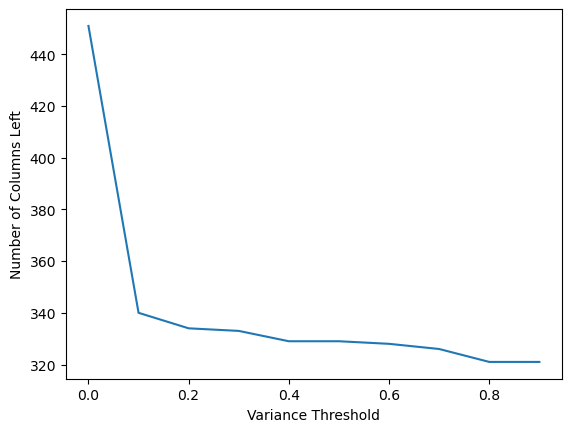

In [11]:
import matplotlib.pyplot as plt
x=np.arange(0,1,0.1)

plt.ylabel("Number of Columns Left")
plt.xlabel("Variance Threshold")
plt.plot(x,nof_below_variance_features)

A variance threshold of 0.1 seems reasonable - we can get rid of 100 features - but there is little to gain to throw away features with variance higher than that.

In [12]:
low_variance_columns = variances[variances <= 0.8].index
df_high_var = data.drop(columns=low_variance_columns)

In [13]:
y = df_high_var.iloc[:,-1]
y

0      P
1      P
2      P
3      P
4      P
      ..
169    H
170    H
171    H
172    H
173    H
Name: class, Length: 174, dtype: object

In [14]:
X = df_high_var.iloc[:,:-1]
X

,air_time1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_gmrt1,mean_speed_in_air1,mean_speed_on_paper1,num_of_pendown1,paper_time1,...,gmrt_on_paper25,max_x_extension25,max_y_extension25,mean_gmrt25,mean_speed_in_air25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
0,5160,120.804174,86.853334,957,6601,103.828754,1.828076,1.493242,22,10730,...,219.829989,10066,13235,249.729085,5.596487,71,40120,1749.278166,296102.7676,144605
1,51980,115.318238,83.448681,1694,6998,99.383459,1.817744,1.517763,11,12460,...,68.398886,7365,15282,77.258394,1.665973,129,126700,1504.768272,278744.2850,298640
2,2600,229.933997,172.761858,2333,5802,201.347928,3.378343,3.308866,10,6080,...,171.954494,7688,14127,193.667018,4.000781,74,45480,1431.443492,144411.7055,79025
3,2130,369.403342,183.193104,1756,8159,276.298223,5.082499,3.542645,10,5595,...,118.573956,6397,14913,163.065803,4.206746,123,67945,1465.843329,230184.7154,181220
4,2310,257.997131,111.275889,987,4732,184.636510,3.804656,2.180544,8,4080,...,126.678802,4624,15532,147.094679,3.319036,92,37285,1841.702561,158290.0255,72575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2930,241.736477,176.115957,1839,6439,208.926217,4.074893,3.390491,12,5835,...,168.136630,7093,14889,200.568126,4.508709,96,44545,1798.923336,247448.3108,80335
170,2140,274.728964,234.495802,2053,8487,254.612383,4.149653,4.143594,10,4595,...,212.092561,7253,16567,231.243565,4.685573,84,37560,1725.619941,160664.6464,345835
171,3830,151.536989,171.104693,1287,7352,161.320841,2.041489,3.507108,14,4060,...,172.610040,6618,15141,177.935566,3.493815,88,51675,1915.573488,128727.1241,83445
172,1760,289.518195,196.411138,1674,6946,242.964666,4.385103,3.538417,8,4425,...,172.610040,6618,15141,177.935566,3.493815,88,51675,1915.573488,128727.1241,83445


In [15]:
# Separate features and target (if applicable)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mmc = MinMaxScaler()
X_scaled = mmc.fit_transform(X)

"""
ssc = StandardScaler()
X_scaled = ssc.fit_transform(X)
"""

'\nssc = StandardScaler()\nX_scaled = ssc.fit_transform(X)\n'

In [16]:
# Perform PCA

pca = PCA(n_components=0.75, svd_solver = 'full')
principal_components = pca.fit_transform(X_scaled)

# Create a new DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_high_var['class'] = df_high_var['class'].replace({'H': 0, 'P': 1})
pc_df['class'] = df_high_var['class']

In [17]:
pc_df.shape

(174, 37)

In [18]:
from sklearn.model_selection import train_test_split

X = pc_df.drop('class',axis = 1)
y = pc_df['class']
X_train , X_test , y_train , y_test = train_test_split(X,y,train_size = 0.8,random_state = 11)

In [19]:
# Create an XGBoost model
xgb_model = xgb.XGBClassifier( objective ='binary:logistic', max_depth = 4, learning_rate = 0.01, n_estimators = 400 )

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

[20:50:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<Figure size 1000x500 with 0 Axes>

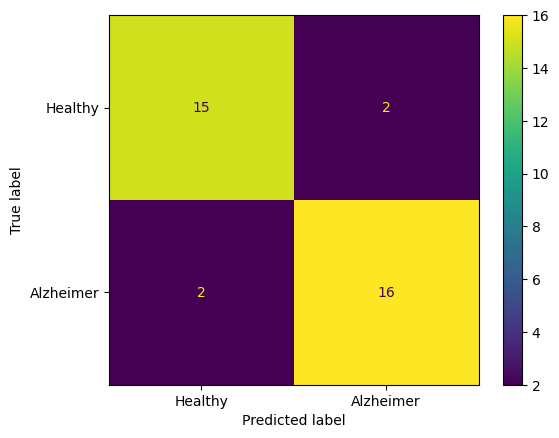

In [20]:
# Creating the confusion matrix 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef

confusion_matrix =confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Healthy", "Alzheimer"])
plt.figure(figsize = (10,5))
cm_display.plot()
plt.show()

In [21]:
# Checking the F1 score of the model
f1 = f1_score(y_test, y_pred)
print(f"{f1:.3}")

0.889


In [60]:
mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f"{mcc:.3}")

0.771
